# Data Cleaning process


In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")
import json
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
from numba import jit

In [2]:
def log_writer(logfile,content):
    with open(logfile,'a') as file_handler:
        current_time = datetime.datetime.now()
        file_handler.write(str(current_time)+ " " + content + "\n")

In [3]:
def data_clean(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S %Z', errors='coerce')
    mask = df.timestamp.isnull()
    if mask.sum():
        df.loc[mask, "timestamp"] = pd.to_datetime(df[mask]["timestamp"], format='%Y-%m-%d %H:%M:%S.%f %Z',errors='coerce')
        #df['timestamp']=df['ts']
        #df.drop(columns={'ts'},inplace=True)
    else:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
    try:    
        df.drop(columns = {"plant","rnoc_tag_name","value_type","quality"},inplace=True)
    except KeyError:
#         content = " the columns plant,rnoc_tag_name,value_type,quality are not present in the data"
#         log_writer(approot,content)
        print(" columns not found")
    
    new_df = df.pivot_table(index = "timestamp",columns="source_id_neuron",values = "value_float",dropna=False)
    new_df = new_df.reset_index()
#     content = "converted the table to have multiple columns"
#     log_writer(approot,content)
    if new_df['timestamp'].dtypes=='datetime64[ns, UTC]':
        new_df.set_index(new_df['timestamp'],inplace=True)
        new_df = new_df.tz_convert('Asia/Kolkata')
        new_df.drop(columns = "timestamp",axis = 1,inplace=True)
    return new_df

In [4]:

def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

In [5]:

def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM

    for i in range(max(0, g-step),min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step),min(SOM.shape[1], h+step)):
            x_dis=np.square(i - g)
            y_dis=np.square(j - h)
            dist_sq = x_dis + y_dis
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:]) 
    return SOM

In [6]:

def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .01, radius_decay = .01, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
   
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)  
    return SOM

In [24]:
@jit(parallel=True)
def train_SOM_cluster(train_set1,lr):
    clust = []
    for n in range(3):
        SOM = np.random.uniform(low=0.0, high=1.0, size=(25,25,len(train_set1.columns)-1))
        # remove
        print(SOM.shape)
        a=train_set1.loc[train_set1['Group'] == n]
        a.drop('Group',axis=1,inplace=True)
        SOM = train_SOM(SOM, np.array(a),lr, epochs=50)
        print(SOM)
        clust.append(SOM)
    return clust

In [25]:
def test_model(clust,model):
# include data_set1 also
    X_test = final_df.iloc[int(len(final_df) * .7):]
    df = final_df.iloc[int(len(final_df) * .7):]
    
    X_test.reset_index('timestamp',inplace=True)
    df.reset_index('timestamp',inplace=True)
    
    df.drop('timestamp',axis=1,inplace=True)
    X_test.drop('timestamp',axis=1,inplace=True)
    
    test=X_test.copy()
    train_set1 = df.copy()

    
    
    testing_columns = ['/GHANI_531C/CTR/WMS/RADIATION_GII', '/GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY']
    i=0 
    for column in test.columns:
        test[column] = test[column] / train_set1[column].abs().max()
    for col_endwith in testing_columns:
        for col in test.columns:
            if col.endswith(col_endwith):
                test[col].iloc[i*40:(i*40+20)] = np.nan
                i+=1
    missing = ~np.isfinite(test)
    mu = np.nanmean(test, 0, keepdims=1)
    Test10 = np.where(missing, mu, test)
    label = model.predict(Test10)

 
    for i in range(len(label)):
        c=label[i]
        coor=find_BMU(clust[c],Test10[i].reshape(1,X_test.shape[1]))
        a=coor[0]
        b=coor[1]
        for j in range(test.shape[1]):
            if missing.values[i][j]==True:
                vector=clust[c][a][b]
                Test10[i][j] = vector[j]

    Final= pd.DataFrame(Test10, columns =df.columns)
    for column in Final.columns:
        Final[column] = Final[column] * train_set1[column].abs().max()

    
    
    Root_Mean_Squared_Error = 0
    for col_endwith in testing_columns:
        for col in Final.columns:
            if col.endswith(col_endwith):
                Root_Mean_Squared_Error = Root_Mean_Squared_Error + np.sqrt(mean_squared_error(Final[col], X_test[col]))
                print(" RMSE "+str(Root_Mean_Squared_Error))
    
    return Final,X_test,missing,(Root_Mean_Squared_Error / len(testing_columns))

In [9]:
def Plot(Final,X_test,missing):
    testing_columns = ['/GHANI_531C/CTR/WMS/RADIATION_GII', '/GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY']
    for col_endwith in testing_columns:
        for col in Final.columns:
            if col.endswith(col_endwith):
                i=list(Final[col])
                r=list(X_test[col])
                m=list(missing[col])
                miss=[]
                for j in range(len(i)):
                    if m[j]:
                        miss.append(0)
                    else:
                        miss.append(r[j])
                feat_df=pd.DataFrame(pd.DataFrame({"missing":miss,'imputed':i,"real":r}))
                feat_df.iloc[0:300].plot(subplots=False,title=col)
            
                i=list(Final[col])
                r=list(X_test[col])
                m=list(missing[col])
                miss=[]
                for j in range(len(i)):
                  if m[j]:
                    miss.append(0)
                  else:
                    miss.append(r[j])
                feat_df=pd.DataFrame(pd.DataFrame({"missing":miss,'imputed':i,"real":r}))
                feat_df.iloc[0:200].plot(subplots=False,title=col)



In [10]:
data  = pd.read_json("C:\\Users\\30028133\\Downloads\\bq-results-20211213-152823-uu1r51hy0qdt.json", lines=True)
if len(data) == 0 :
    raise ValueError("No records in the input dataset")

# remove below code as it is already added in preprocessing part
#     content = "data read"
#     log_writer(approot,content)
#     print(data.columns)
data_set1 = data.copy()
#     content = "data copied to a new variable data_set1"
#     log_writer(approot,content)
# data_set1["timestamp"] = pd.to_datetime(data_set1["timestamp"], errors='coerce')
#     content = "converted timestamp"
#     log_writer(approot,content)


In [11]:
data_set1

plant         rnoc_tag_name value_type  \
0       GHANI  EXPORT_ACTIVE_ENERGY     number   
1       GHANI         GII_RADIATION     number   
2       GHANI         GII_RADIATION     number   
3       GHANI         GHI_RADIATION     number   
4       GHANI         GII_RADIATION     number   
...       ...                   ...        ...   
612491  GHANI         GII_RADIATION     number   
612492  GHANI         GHI_RADIATION     number   
612493  GHANI         GHI_RADIATION     number   
612494  GHANI         GII_RADIATION     number   
612495  GHANI         GHI_RADIATION     number   

                                         source_id_neuron  value_float  \
0       /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXP...     88557.91   
1                       /GHANI_531C/CTR/WMS/RADIATION_GII         0.00   
2                       /GHANI_531C/CTR/WMS/RADIATION_GII         1.00   
3                       /GHANI_531C/CTR/WMS/RADIATION_GHI         0.00   
4                       /GHANI_531C/CTR/WMS/RADIATION_GII         0.00   
...                                                   ...          ...   
612491                  /GHANI_531C/CTR/WMS/RADIATION_GII         0.03   
612492                  /GHANI_531C/CTR/WMS/RADIATION_GHI         0.38   
612493                  /GHANI_531C/CTR/WMS/RADIATION_GHI         0.02   
612494                  /GHANI_531C/CTR/WMS/RADIATION_GII         0.00   
612495                  /GHANI_531C/CTR/WMS/RADIATION_GHI         0.00   

        quality                        timestamp  
0           192        2021-01-01 00:05:00+00:00  
1           192        2021-01-01 00:05:00+00:00  
2           192        2021-01-01 00:05:00+00:00  
3           192        2021-01-01 00:05:00+00:00  
4           192        2021-01-01 00:05:00+00:00  
...         ...                              ...  
612491      192 2021-11-30 12:11:54.657000+00:00  
612492      192 2021-11-30 12:11:54.657000+00:00  
612493      192 2021-11-30 12:12:54.686000+00:00  
612494      192 2021-11-30 12:12:54.686000+00:00  
612495      192 2021-11-30 12:13:54.661000+00:00  

[612496 rows x 7 columns]

In [12]:
pre_processed_df=data_clean(data_set1)

In [13]:
#----------------------------------------------------------------------------------------------------------------------
final_df = pre_processed_df.interpolate(method='time')
final_df =pre_processed_df.resample('5min').mean()
final_df = final_df.drop_duplicates()
final_df = final_df.between_time('6:30', '18:30')
#final_df.drop(['/LHS_LT_PANEL/MFM_LT_PANEL/IMPORT_ACTIVE_ENERGY','/RHS_LT_PANEL/MFM_LT_PANEL/IMPORT_ACTIVE_ENERGY'],axis = 1,inplace=True)
final_df.dropna(inplace=True)
# ----------------------------------------------------------------------------------------------------------------------
# for col in data_set1.columns :
#     ##  check for other columns
#     if col.endswith('REACTIVE_POWER') or col.endswith('IMPORT_ACTIVE_ENERGY'):
#           if len(data_set1[col].unique())==1:
#                 if data_set1[col].unique()==0: #i.e it has only zero value
#                     print('Only zero present in {} column'.format(col))
#                     data_set1.drop(columns = {col},inplace=True)

rand = np.random.RandomState(0)

  ## remove this code          
train_set1 = final_df.iloc[0:int(len(final_df) * .7)]
#print(train_set1.head())
#     content = "train data created"
#     log_writer(approot,content)

train_set1.reset_index('timestamp',inplace=True)
train_set1.drop('timestamp',axis=1,inplace=True)

for typ in train_set1.dtypes:
    if typ not in ['float64','int64']:
        raise TypeError("Only Numeric values allowed") 

# print(train_set1.max())
# print(train_set1.columns)
# print(len(train_set1.columns))

# check for different scaling method
for column in train_set1.columns:
    train_set1[column] = train_set1[column] / train_set1[column].abs().max()

    
#from sklearn.utils import shuffle
#train_set1 = shuffle(train_set1)


# train_set1.to_csv("train_data.csv",index=False)
#     content = "executing KMeans"
#     log_writer(approot,content)
# train_set1.to_csv('train_set1.csv',index=False)

In [14]:
train_set1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28649 entries, 0 to 28648
Data columns (total 3 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY  28649 non-null  float64
 1   /GHANI_531C/CTR/WMS/RADIATION_GHI                                28649 non-null  float64
 2   /GHANI_531C/CTR/WMS/RADIATION_GII                                28649 non-null  float64
dtypes: float64(3)
memory usage: 671.6 KB


In [15]:
train_set1.describe()

source_id_neuron  /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY  \
count                                                  28649.000000                 
mean                                                       0.909818                 
std                                                        0.054058                 
min                                                        0.813452                 
25%                                                        0.862737                 
50%                                                        0.911625                 
75%                                                        0.956956                 
max                                                        1.000000                 

source_id_neuron  /GHANI_531C/CTR/WMS/RADIATION_GHI  \
count                                  28649.000000   
mean                                       0.369501   
std                                        0.241076   
min                                        0.000000   
25%                                        0.148846   
50%                                        0.348172   
75%                                        0.595375   
max                                        1.000000   

source_id_neuron  /GHANI_531C/CTR/WMS/RADIATION_GII  
count                                  28649.000000  
mean                                       0.346726  
std                                        0.230989  
min                                        0.000000  
25%                                        0.140658  
50%                                        0.325222  
75%                                        0.520633  
max                                        1.000000

In [16]:
train_set1['/GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY'].unique()

array([0.81345202, 0.81345239, 0.81345284, ..., 0.99999192, 0.99999585,
       1.        ])

In [17]:
train_set1['/GHANI_531C/CTR/WMS/RADIATION_GHI'].unique()

array([0.        , 0.00041044, 0.00184698, ..., 0.21845213, 0.23501656,
       0.19801378])

In [18]:
train_set1['/GHANI_531C/CTR/WMS/RADIATION_GHI'].unique()

array([0.        , 0.00041044, 0.00184698, ..., 0.21845213, 0.23501656,
       0.19801378])

In [19]:
km = KMeans(n_clusters=3, random_state=0, n_init=30)
km.fit(train_set1)
label = km.predict(train_set1)
train_set1['Group'] = label
train_set1['Group'].value_counts()
#     content = "k-means label assigned"
#     log_writer(approot,content)

print('Saving pickle file.')
filename = 'final_WMS_km_01.sav'

Saving pickle file.


In [20]:
train_set1.Group.unique()

array([0, 2, 1])

In [21]:
train_set1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28649 entries, 0 to 28648
Data columns (total 4 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   /GHANI_531C/CTR/SWTGR/INC01/MFM_SWGR_ELITE/EXPORT_ACTIVE_ENERGY  28649 non-null  float64
 1   /GHANI_531C/CTR/WMS/RADIATION_GHI                                28649 non-null  float64
 2   /GHANI_531C/CTR/WMS/RADIATION_GII                                28649 non-null  float64
 3   Group                                                            28649 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 783.5 KB


In [26]:
pickle.dump(km, open(filename, 'wb'))
#     content = "pickle file saved"
#     log_writer(approot,content)

learning_rate = [0.01,0.07,0.1,0.2] 
rmse_list     = []

cluster = [] 
for lr in learning_rate:
    #print('Testing for learning rate {}. \n'.format(lr))
    clust = []
    #print('Forming SOM cluster...')
    clust = train_SOM_cluster(train_set1,lr)
    #print(clust)

    print('Finding RMSE value for learning rate {}.'.format(lr))
    Final,X_test,missing,rmse = test_model(clust,km)
    rmse_list.append(rmse)
print('Final RMSE list : ',rmse_list)
final_lr = learning_rate[rmse_list.index(min(rmse_list))]
print('Best learning rate: ',final_lr)
#     content = "Finding final learning rate from given RMSE list"
#     log_writer(approot,content)

#     content = "Saving model files for best learning rate found"
clust = train_SOM_cluster(train_set1,final_lr)
print('Saving weighted matrix into numpy.')
np.save("final_WMS_weights_01",np.array(clust))
#     log_writer(approot,content)

(25, 25, 3)
[[[0.9927499  0.1380563  0.14267943]
  [0.99262343 0.12773551 0.13227684]
  [0.99250203 0.11335859 0.11752175]
  ...
  [0.81832776 0.0327967  0.02571172]
  [0.81787943 0.01950244 0.01548654]
  [0.81730105 0.01040149 0.00853623]]

 [[0.99142264 0.13178399 0.13591566]
  [0.99178133 0.12169908 0.12570636]
  [0.99194188 0.1087941  0.1124803 ]
  ...
  [0.82264646 0.02915337 0.02275479]
  [0.82040137 0.01325136 0.01061655]
  [0.81885162 0.00535616 0.00456263]]

 [[0.97889087 0.09911613 0.10162181]
  [0.98290514 0.09735805 0.09987102]
  [0.98651737 0.09144021 0.09350244]
  ...
  [0.8304796  0.02488499 0.01898171]
  [0.82757885 0.01065183 0.00843169]
  [0.8251516  0.00386032 0.00341819]]

 ...

 [[0.52078214 0.48780102 0.7265932 ]
  [0.62364778 0.4889602  0.78145733]
  [0.23928407 0.85723229 0.12644212]
  ...
  [0.98329439 0.19989208 0.21003949]
  [0.99060247 0.21111512 0.21991627]
  [0.99287873 0.21829228 0.22553183]]

 [[0.38407718 0.63040976 0.39655954]
  [0.09267895 0.04671652 

 RMSE 3.002554913989196
 RMSE 129.03723394528672
(25, 25, 3)
[[[0.940556   0.24190526 0.19117362]
  [0.94779794 0.22908725 0.1886154 ]
  [0.96176334 0.2122221  0.18370255]
  ...
  [0.99364353 0.08925673 0.09287898]
  [0.99311812 0.09912782 0.10360636]
  [0.99349379 0.10620781 0.11097209]]

 [[0.9553323  0.23701035 0.20156969]
  [0.96294344 0.22496825 0.19801386]
  [0.97513374 0.20896815 0.19263616]
  ...
  [0.99283358 0.09302751 0.09585774]
  [0.99257856 0.10395457 0.10804799]
  [0.99347585 0.11133242 0.11616491]]

 [[0.97850191 0.22630415 0.21433733]
  [0.98467652 0.21579864 0.21058022]
  [0.98981489 0.20444876 0.20486147]
  ...
  [0.99086848 0.09763584 0.09938157]
  [0.99139088 0.11121988 0.1150967 ]
  [0.99269295 0.11847504 0.12368923]]

 ...

 [[0.81959659 0.05809496 0.04577721]
  [0.8241432  0.05422052 0.04305784]
  [0.83031098 0.04732217 0.03744193]
  ...
  [0.82896625 0.09783406 0.07801479]
  [0.82112516 0.101862   0.08206663]
  [0.81780469 0.10676698 0.0836075 ]]

 [[0.81863549

 RMSE 3.3698926315710875
 RMSE 131.20004654354742
Final RMSE list :  [67.35042377621988, 64.51861697264336, 62.77803814954848, 65.60002327177371]
Best learning rate:  0.1
(25, 25, 3)
[[[0.81738491 0.11106066 0.08424079]
  [0.81802784 0.11969305 0.09292133]
  [0.81903263 0.13081393 0.10228717]
  ...
  [0.91605691 0.22179937 0.21573143]
  [0.92226146 0.22971455 0.22364206]
  [0.92728897 0.23333804 0.23044134]]

 [[0.81747994 0.10311643 0.07925855]
  [0.81890576 0.11050787 0.08763646]
  [0.8214373  0.12248412 0.09813034]
  ...
  [0.90573693 0.22428653 0.2156185 ]
  [0.91126366 0.23276227 0.22159794]
  [0.91559518 0.23372052 0.2287276 ]]

 [[0.81804967 0.09347406 0.07245326]
  [0.82090594 0.09693584 0.0770021 ]
  [0.82685108 0.10573976 0.08536477]
  ...
  [0.89231392 0.22263668 0.21706703]
  [0.8954788  0.23138702 0.22306174]
  [0.8970317  0.23114383 0.23043674]]

 ...

 [[0.83656243 0.00253466 0.00242258]
  [0.83910798 0.00598013 0.00502298]
  [0.84651286 0.01173183 0.00940634]
  ...
  [0

Plotting the graphs...


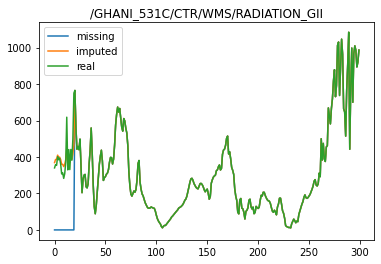

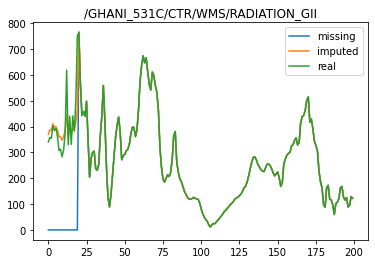

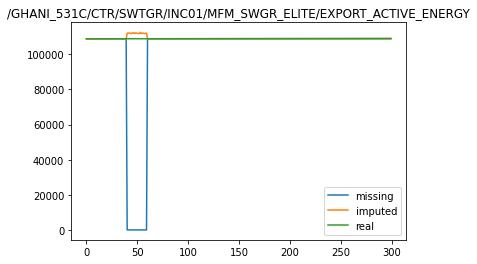

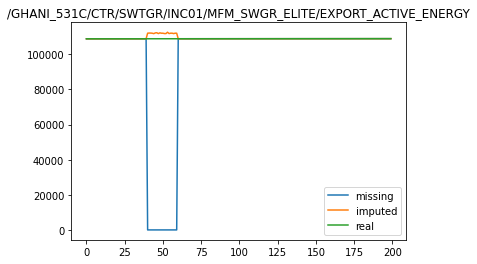

In [27]:
print('Plotting the graphs...')
Plot(Final,X_test,missing)
#         trafo_data.to_json("final_preprocessed_trafo_blk04.json")
